# The El-Niño Southern Oscillation

An example of a spatio-temporal climate oscillation pattern that can be summarized in a single time series.

> "Experience precedes technical knowlegde." - W. Timothy Gallwey (*The Inner Game of Tennis*)

- a step-by-step guide for calculating the ENSO index based on SST data
- you will learn how to:
    - load a file
    - manipulate a dataset
    - apply a method (matrix factorization: SVD)
    - explore and interpret the results
    - perform a lead/lag correlation analysis
    - pretty plot the final results

## What is ENSO?

- one of the largest modes of (internal) climate variability

- affects the climate of much of the tropics and subtropics

- comes in two phases: *El Niño* and *La Niña*

- both extremes can cause extreme weather (such as floods and droughts) in many regions of the world

![normal conditions](images/normal-conditions.png)

![El Niño conditions](images/el_nino-conditions.png)

The ENSO **index** is used to monitor the tropical Pacific and seasonal forecasting is a hot topic.

[![NOAA NINO3.4 SST index](images/enso3.4_noaa.png)](https://www.ncdc.noaa.gov/teleconnections/enso/indicators/sst/) 

## Why do we care?

In [1]:
from IPython.display import Video
# source: https://niwa.co.nz/climate/information-and-resources/elnino
Video("images/la_nina.mp4",width=800)

# Can we come up with an ENSO index ourselves?

Or, getting from here...

In [2]:
import xarray as xr
ds = xr.open_dataset("sst.nc")
with xr.set_options(display_expand_attrs=False):
    display(ds)

<xarray.Dataset>
Dimensions:  (T: 2012, Y: 89, zlev: 1, X: 180)
Coordinates:
  * T        (T) object 1854-01-16 00:00:00 ... 2021-08-16 00:00:00
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
  * zlev     (zlev) float32 0.0
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
Data variables:
    sst      (T, zlev, Y, X) float32 ...
Attributes: (2)

...to here.
![NOAA NINO3.4 SST index](images/enso3.4_noaa.png)

# What we want to do

1. Prepare *Sea Surface Temperature* (SST) for the *NINO3.4* region

2. Decompose *spatio-temporal* SST dataset into *principal components*

3. Create spatial *correlation* maps using principal components

# Prepare *Sea Surface Temperature* (SST) for the *NINO3.4* region

- [ERSSTv5](https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/index.html) sea surface temperature dataset (find it on the OSF repository)

```bash
wget https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/sst/data.nc -O sst_orig.nc
```

- In this specific dataset the calendar attribute of the time dimension `T` is set to `360` but `xarray` expects `360_day` instead (Bummer!).

- Use NCO attribute editor `ncatted` (part of `nco` toolbox):
```bash
ncatted -a calendar,T,o,c,"360_day" sst_orig.nc sst.nc
```

## Interactive notebook(s)

**Requirements**:
To run this and other Jupyter notebooks, you need to have a few Python packages pre-installed. For package management, we recommend using `conda`, so you can set up different environments for different projects, without worrying about incompatibility issues.

We use [`xarray`](http://xarray.pydata.org/en/stable/) to do the heavy-lifting of reading `NetCDF` files. Making nice geographic maps is relatively easy with [`cartopy`](https://scitools.org.uk/cartopy/docs/latest/). The other (standard) packages are [`matplotlib`](https://matplotlib.org/) for plotting, [`numpy`](https://numpy.org/) numerical manipulation of numbers, vectors, and arrays, [`scipy`](https://docs.scipy.org/doc/scipy/reference/) for detrending, and [`pandas`](https://pandas.pydata.org/) for time series analysis (and plotting as well).

Import all packages and click on (<i class="fa-play fa"></i><span class="toolbar-btn-label">Run</span></button>)

In [3]:
%matplotlib inline
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import imageio
from scipy.signal import detrend
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['font.size'] = 18

## detrending and removing climatology
After loading our data, we need to remove the trend and subtract the monthly climatologies for our analysis. For the de-trending we use `scipy`'s `detrend` function. As it doesn't like `NaN`'s, we fill them with zeros. For the climatologies, we make use of the `apply` method which applies our custom-made `subtract` method to all monthly values (`groubby` creates unique labels along a dimension, e.g., 1, 2, 3, ... 12, for all the months).

We can double-check if the climatologies have been removed, by picking a random location and plotting the long-term monthly mean values (i.e., climatologies) before and after `apply`.

In [4]:
# load SST file into data sets 
ds_sst = xr.open_dataset("sst.nc").squeeze("zlev").drop("zlev")

# we give the dimensions a standard name, e.g., "T" -> "time", etc.
new_dims = {'T': 'time', 'Y': 'latitude', 'X': 'longitude'}
ds_sst = ds_sst.rename(new_dims).set_coords(['longitude', 'latitude', 'time'])

# select a time period using ".sel()"
# and "slice" the time for the period between 1950 and 2021
ds_sst = ds_sst.sel(time=slice("1949-10","2021"))

In [5]:
# define a function that subtracts the mean along the "time" dimension
def subtract(x):
    return x - x.mean(dim="time")

# define our custom detrend function that also fills NaNs with 0s
def detrend_(x):
    return detrend(x.fillna(0),axis=0)

In [6]:
# we'll keep a copy after each step as reference ("ds0","ds1","ds2")
# but override "ds_sst"
ds0 = ds_sst*1.0

# apply the detrending
ds_sst = ds_sst.apply(detrend_)
ds1 = ds_sst*1.0

# apply the subtraction of the monthly means, using "groupby"
ds_sst = ds_sst.groupby("time.month").apply(subtract)
ds2 = ds_sst*1.0

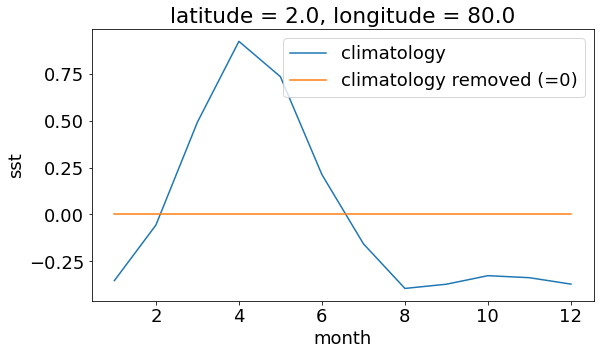

In [7]:
# plot the climatological monthly means as time series for a location (80E, 2N)
ds1["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology")
ds2["sst"].groupby("time.month").mean() \
    .sel(longitude=80,latitude=2).plot(label="climatology removed (=0)")
plt.legend();

## Picking the region

> **Niño 1+2 (0-10S, 90W-80W)**: The Niño 1+2 region is the smallest and eastern-most of the Niño SST regions, [...]
>
> **Niño 3 (5N-5S, 150W-90W)**: This region was once the primary focus for monitoring and predicting El Niño, but researchers later learned that the key region for coupled ocean-atmosphere interactions for ENSO lies further west [...]
> 
> **Niño 3.4 (5N-5S, 170W-120W)**: The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific [...]
> 
> **Niño 4 (5N-5S, 160E-150W)**: The  Niño 4 index captures SST anomalies in the central equatorial Pacific.  This region tends to have less variance than the other Niño regions.

(source: https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

In [8]:
# define Nino3.4 region boundaries
lon1 = 360-170; lon2 = 360-120
lat1 = -5; lat2 = 5
# also the other NINO regions
# Nino1.2
lon1_12 = 360-90; lon2_12 = 360-80
lat1_12 = -10; lat2_12 = 0
# Nino3
lon1_3 = 360-150; lon2_3 = 360-90
lat1_3 = -5; lat2_3 = 5
# Nino4
lon1_4 = 160; lon2_4 = 360-150
lat1_4 = -5; lat2_4 = 5

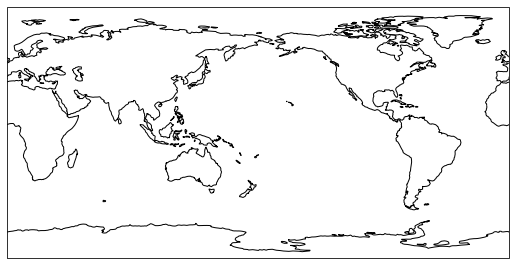

In [9]:
# define projection of SST data: lonlat grid -> "PlateCarree()"
data_proj = ccrs.PlateCarree()
# define projection for maps
proj = ccrs.PlateCarree(central_longitude=180)

# create figure and axis with map projection
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj})
# draw some coastlines
ax.coastlines();

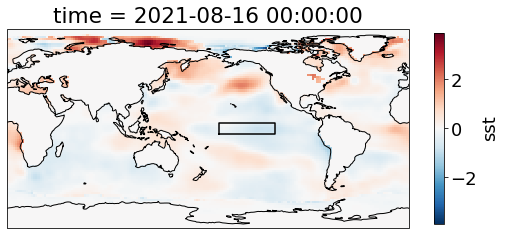

In [10]:
# plot SST anomalies for last month,
# i.e, the last time index, -1
ds_sst["sst"][-1].plot(ax=ax,transform=data_proj,cbar_kwargs={"shrink": 0.7})
# plot extend of Nino3.4
nino34 = [lon1,lon2,lon2,lon1,lon1],[lat1,lat1,lat2,lat2,lat1]
ax.plot(*nino34,'k-',transform=data_proj)
fig

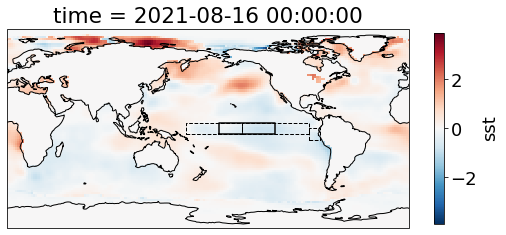

In [11]:
# add other Nino region outlines 
nino12 = [lon1_12,lon2_12,lon2_12,lon1_12,lon1_12],[lat1_12,lat1_12,lat2_12,lat2_12,lat1_12]
ax.plot(*nino12,'k--',lw=1,transform=data_proj)
nino3 = [lon1_3,lon2_3,lon2_3,lon1_3,lon1_3],[lat1_3,lat1_3,lat2_3,lat2_3,lat1_3]
ax.plot(*nino3,'k--',lw=1,transform=data_proj)
nino4 = [lon1_4,lon2_4,lon2_4,lon1_4,lon1_4],[lat1_4,lat1_4,lat2_4,lat2_4,lat1_4]
ax.plot(*nino4,'k--',lw=1,transform=data_proj);
fig

In [12]:
# slice dataset along Nino3.4 boundaries
# i.e., between "lon1" and "lon2",
# and between "lat1" and "lat2"
sst = ds_sst["sst"].loc[{
    'latitude': slice(lat1,lat2),
    'longitude': slice(lon1,lon2)
}]

# fill all masked values (land) with 0s
x = sst.fillna(0).values
# print dimensions of Nino3.4 SST data
print("Original dimensions:", x.shape)

# save the dimensions
nt, ny, nx = x.shape

# reshape array into matrix with time and space dimension, only
# i.e, nt,nx*ny
x = np.reshape(x,(nt,ny*nx))
print("New dimensions:     ",x.shape)
# store number of principipal components (for later)
n_components = nx*ny

Original dimensions: (863, 5, 26)
New dimensions:      (863, 130)


Let's now apply a *Singular Value Decomposition* to the matrix `x`

In [13]:
# THIS LINE HERE IS WHERE THE WHOLE ACTION IS!
u, s, vh = np.linalg.svd(x, full_matrices=False)

# print dimensions of returned matrices
print(u.shape, s.shape, vh.shape)

(863, 130) (130,) (130, 130)


- `u` contains the temporal representation (time series) of the **principal components**

- `s` contains the eigenvalues of the **principal components**

- `vh` contains the spatial representation (spatial maps) of of the **principal components**

In [14]:
# Let's retrieve the temporal component, i.e., the PCs
coords = [
    ("time", sst["time"].data),
    ("PC",range(1,n_components+1))
]
pc = xr.DataArray(np.dot(u, np.diag(s))/np.sqrt(n_components), coords=coords).to_pandas()
# a 3-month running mean using "rolling(3)"
pc_3m = pc.rolling(3).mean()
# get the time stamps for the x-axis dates
time = pc.index.to_datetimeindex()
time_3m = pc_3m.index.to_datetimeindex()

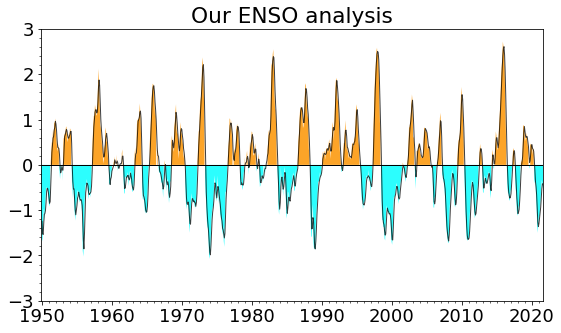

In [15]:
# and plot it all
plt.fill_between(time,pc[1],0,where=(pc[1] > 0), lw=0, color='#fca428')
plt.fill_between(time,pc[1],0,where=(pc[1] < 0), lw=0, color='#2cfefe')
plt.plot(time_3m,pc_3m[1],'k-',lw=1,alpha=0.75)
plt.axhline(0,c='k',zorder=1,lw=1)
plt.xlim(time[0],time[-1])
plt.title("Our ENSO analysis")
plt.gca().xaxis.set_minor_locator(mdates.YearLocator())
plt.gca().yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-3,3.1,0.2)))
plt.ylim(-3,3)
plt.savefig("images/our_enso.png",dpi=300)

 And here's how it compares to NOAA's NINO3.4 index
 <table>
    <tr>
        <td><img src="images/our_enso.png" alt="OUR NINO3.4 SST index" width="600" align="center"></td>
        <td><img src="images/enso3.4_noaa.png" alt="NOAA NINO3.4 SST index" width="600" align="center"></td>
    </tr>
</table>

# What just happened?

# Decompose *spatio-temporal* SST dataset into *principal components*

The SST (or any spatio-temporal) dataset can be re-arranged into a *matrix*, $M$, with *rows* representing the time  series of each location (*columns*)

$$
M = \begin{bmatrix}
    x_{11}       & x_{12} & x_{13} & \dots & x_{1n} \\
    x_{21}       & x_{22} & x_{23} & \dots & x_{2n} \\
     \vdots & \vdots & \vdots & \ddots & \vdots \\
    x_{t1}       & x_{t2} & x_{t3} & \dots & x_{tn}
\end{bmatrix}
$$

In [16]:
# fill all masked values (land) with 0s
x = sst.fillna(0).values
# print dimensions of Nino3.4 SST data
print(x.shape)

# save the size of each dimension
nt, ny, nx = x.shape

# reshape array into matrix with time and space dimension, only
# i.e, nt,nx*ny
x = np.reshape(x,(nt,ny*nx))
print(x.shape)

(863, 5, 26)
(863, 130)


(863, 130)


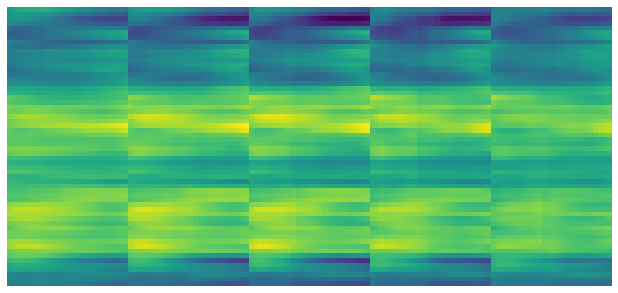

In [17]:
print(x.shape)
# plot matrix for last 5 years (=60 months)
plt.matshow(x[:60,:])
plt.gca().set_axis_off()

Before we get back to this high-dimensional example, let's have a look at a simpler 2D case with a matrix of shape `(nt,2)`, so we get a feeling of what's going on. 

# SVD explained

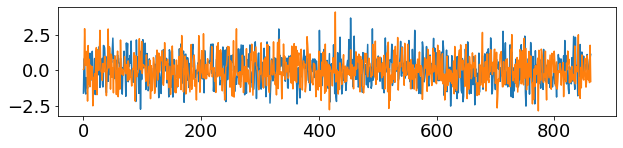

In [18]:
rng = np.random.default_rng(1234) # random number generator instance

C = np.array([[1,0],[0,1]])
Z = rng.multivariate_normal(mean=[0,0],cov=C,size=(nt))

plt.figure(figsize=(10,2))
plt.plot(Z[:,0])
plt.plot(Z[:,1]);

In [19]:
# rotation matrix R
np.set_printoptions(precision=4)
theta = np.pi/4
print(f"θ = {np.degrees(theta)}°")
R = np.array([[np.cos(theta),-np.sin(theta)],[np.sin(theta),np.cos(theta)]])
print("R=")
print(R)
# inverse of rotation matrix R
R_inv = np.linalg.inv(R)
print("R_inv=")
print(R_inv)
# stretch matrix S
S = np.diag([2**0.5,1])
print("S=")
print(S)

θ = 45.0°
R=
[[ 0.7071 -0.7071]
 [ 0.7071  0.7071]]
R_inv=
[[ 0.7071  0.7071]
 [-0.7071  0.7071]]
S=
[[1.4142 0.    ]
 [0.     1.    ]]


In [20]:
# define method to create a phase plot of two timeseries
def plot_xy(x,y,ax,xlab=None,ylab=None,title=None,off=False,grid=False,color='k'):
    ax.plot(x,y,ls='',marker='o',mew=0,color=color)
    ax.set_aspect("equal")
    ax.set_xlabel(xlab); ax.set_ylabel(ylab)
    ax.set_title(title)
    if off: ax.set_axis_off()
    if grid: ax.grid()

[[2.4384 1.4093]
 [1.4093 2.4533]]


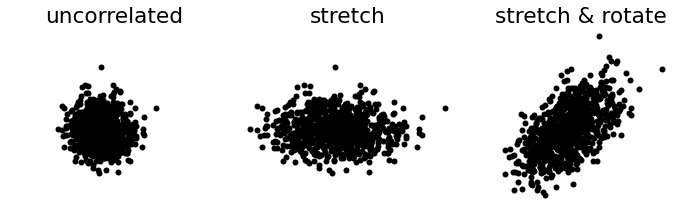

In [21]:
fig, ax = plt.subplots(1,3,figsize=(10,4),sharex=True,sharey=True)
# raw, uncorrelated
plot_xy(Z[:,0],Z[:,1],ax[0],title="uncorrelated",off=True)
# stretch
Zs = np.dot(Z,S@S)
plot_xy(Zs[:,0],Zs[:,1],ax[1],title="stretch",off=True)
# stretch & rotate
Zsr = np.dot(Z,R@S@S@R_inv)
plot_xy(Zsr[:,0],Zsr[:,1],ax[2],title="stretch & rotate",off=True)
fig.tight_layout()
print(np.cov(Zsr.T))

[[2.5 1.5]
 [1.5 2.5]]


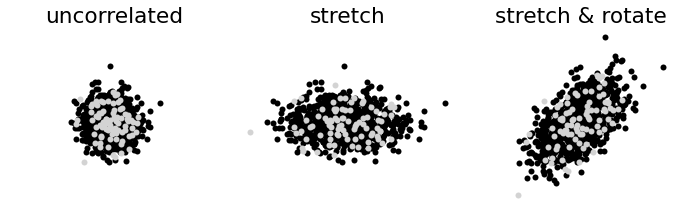

In [22]:
# Let's create two new time series with the same covariance as the 
# "stretched & rotated" dataset 
M = R@S@S@R_inv
print(M@M)
Z2 = rng.multivariate_normal(mean=[0,0],cov=M@M,size=(nt//10)) # use fewer points
plot_xy(Z2[:,0],Z2[:,1],ax[2],title="stretch & rotate",off=True,color='lightgrey')
Z2r = Z2@R
plot_xy(Z2r[:,0],Z2r[:,1],ax[1],title="stretch",off=True,color='lightgrey')
Z2u = Z2@np.linalg.inv(M)
plot_xy(Z2u[:,0],Z2u[:,1],ax[0],title="uncorrelated",off=True,color='lightgrey')

fig.tight_layout()
fig

(86, 2) (2,) (2, 2)


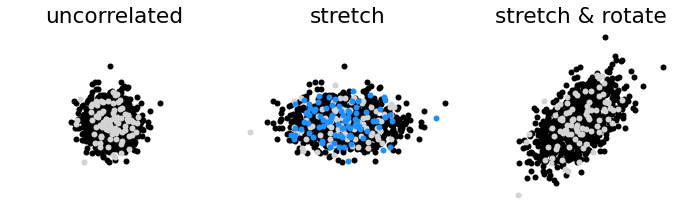

In [23]:
# Now let's do a SVD and compare
u, s, vh = np.linalg.svd(Z2, full_matrices=False)
print(u.shape,s.shape,vh.shape)
Z3 = u@np.diag(s)
plot_xy(Z3[:,0],Z3[:,1],ax[1],title="stretch",off=True,color='dodgerblue')

fig.tight_layout()
fig

## Interactive session (20min)

Break out into groups of 2 or 3 and work through notebook `01-SVD.ipynb`.

Back to our SST dataset...

In [24]:
# store number of principipal components (for later)
n_components = nx*ny

# decompose SST data into spatial and temporal components
# using numpy's linear algebra method "svd":
# Singular Value Decomposition
# THIS LINE HERE IS WHERE THE WHOLE ACTION IS!
u, s, vh = np.linalg.svd(x, full_matrices=False)

# print dimensions of returned matrices
print(u.shape, s.shape, vh.shape)

(863, 130) (130,) (130, 130)


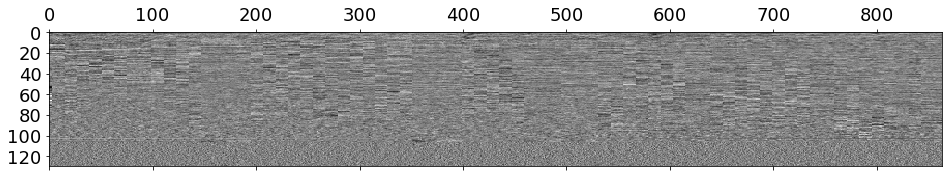

In [25]:
# inspect (transposed) matrix u
plt.matshow(u.T,cmap="gray");

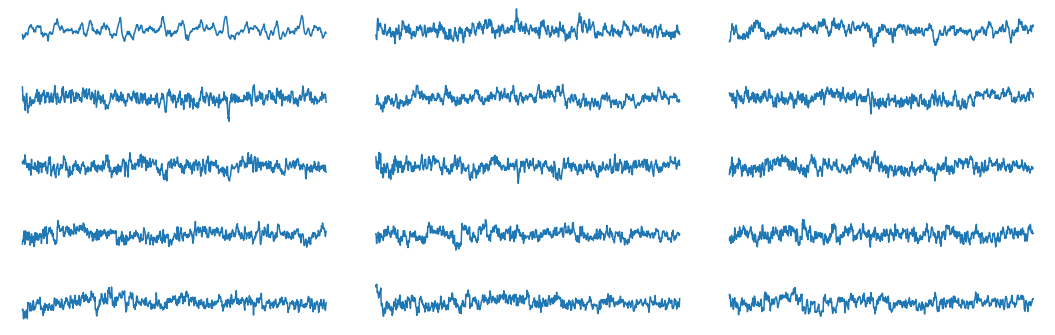

In [26]:
# inspect first 15 elements of "u"
fig, axes = plt.subplots(5,3,sharex=True,sharey=True,figsize=(15,5))
for i,ax in enumerate(axes.flat):
    ax.plot(u[:,i])
    ax.set_axis_off()
fig.tight_layout()

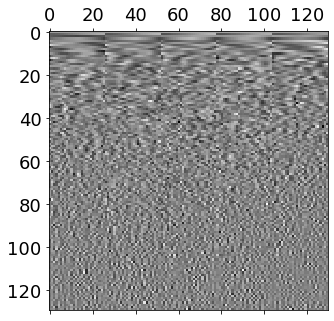

In [27]:
# inspect (already transposed) matrix v
plt.matshow(vh,cmap="gray");

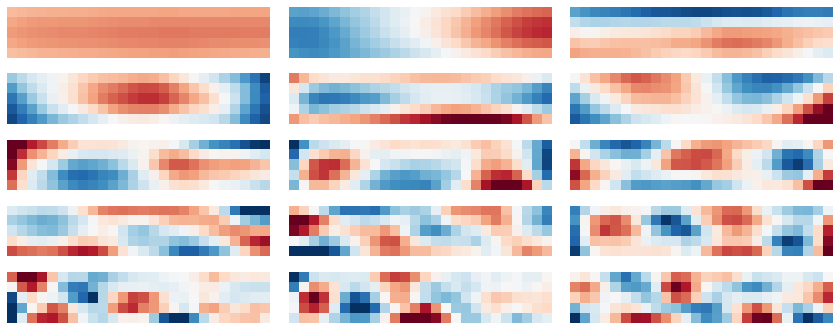

In [28]:
# inspect first 15 elements of "vh"
fig, axes = plt.subplots(5,3,sharex=True,sharey=True,figsize=(12,5))
for i,ax in enumerate(axes.flat):
    # reshape into orginal (ny,nx) shape, i.e., the NINO3.4 region
    im = ax.matshow(np.reshape(vh[i,:],(ny,nx)),cmap="RdBu_r",vmin=-0.2,vmax=0.2)
    ax.set_axis_off()
fig.tight_layout()

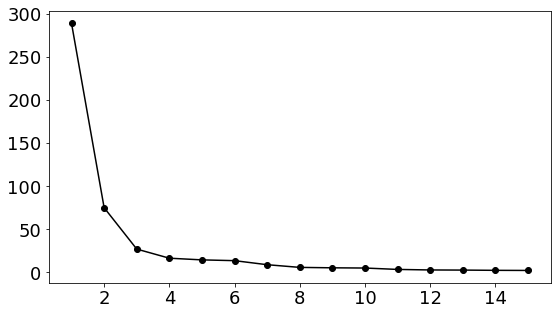

In [29]:
# inspect first 15 (diagonal) elements of matrix "s"
plt.plot(range(1,16),s[:15],'ko-');

Let's tidy everything up a little bit, here.

Total variance of SST data: 0.809341


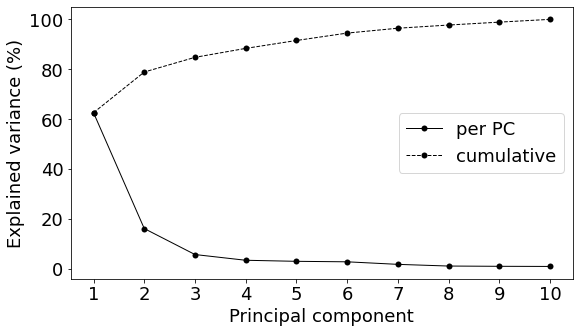

In [30]:
X = s[:10]/np.sum(s[:10])*100
plt.plot(range(1,len(X)+1),X,'ko-',lw=1,mew=0,label='per PC')
plt.xlabel("Principal component")
plt.ylabel("Explained variance (%)")
plt.xticks(range(1,len(X)+1))

plt.plot(range(1,len(X)+1),np.cumsum(X),'ko--',lw=1,mew=0,label='cumulative')
plt.legend();
print("Total variance of SST data: %f"%x.var())

Let's put the resulting data back into a useful `xarray` data structure 

In [31]:
# we refer to the spatial component of the decomposition as EOF
eofs = np.reshape(vh,(n_components,ny,nx))
coords = [ 
    ("n",range(1,n_components+1)),
    ("latitude", sst["latitude"].data),
    ("longitude", sst["longitude"].data)
]
# turn the eofs into an xarray DataArray
eof = xr.DataArray(eofs, coords=coords)

In [32]:
# this is the temporal component, i.e., the PCs
coords = {"time": pd.to_datetime([t.strftime() for t in sst["time"].data]),
          "n": range(1,n_components+1)}
coords = {"time": sst["time"].data,
          "n": range(1,n_components+1)}
ds_pc = xr.Dataset({"PC": (("n","time"), (u@np.diag(s)/np.sqrt(n_components)).T)}, coords=coords)
ds_pc.sel(n=1).drop("n").to_netcdf("our_enso.nc") # save to NetCDF file for later
pc = ds_pc.to_dataframe()

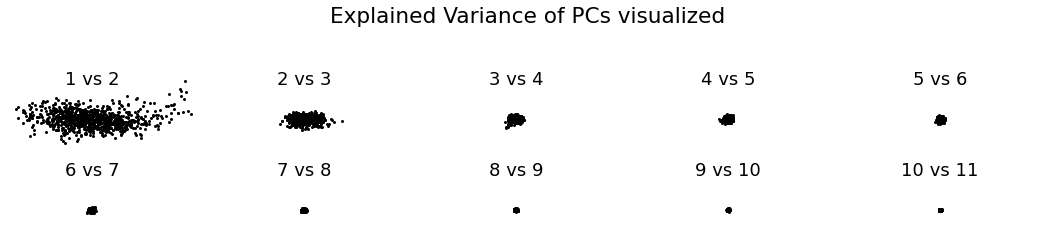

In [33]:
fig, axes = plt.subplots(2,5,sharex=True,sharey=True,figsize=(15,3))
for i,ax in enumerate(axes.flat):
    x = i+1
    y = i+2
    xt,yt = 0,1.1
    ax.plot(pc.loc[x],pc.loc[y],'k.',mew=0)
    ax.text(xt,yt,"%d vs %d"%(x,y),ha='center',va='center')
    ax.set_aspect('equal')
    ax.set_axis_off()
fig.tight_layout()
fig.suptitle("Explained Variance of PCs visualized",y=1.2);

In [34]:
# extract the 1st PC, and scale it
pc1 = pc.loc[1]
pc1.index = pd.to_datetime([t.strftime() for t in sst["time"].data])
# a 3-month running mean using "rolling(3)"
pc1_3m = pc1.rolling(3).mean()
# get the time stamps for the x-axis dates
time = pc1.index
time_3m = pc1_3m.index

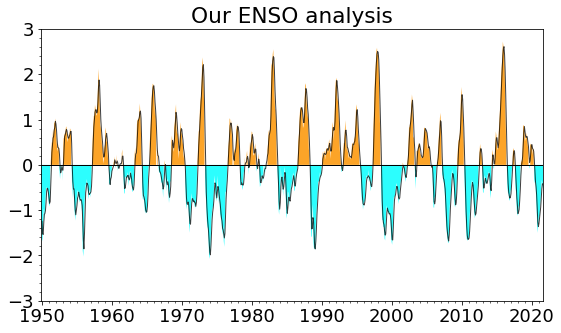

In [35]:
pc1 = pc1.values.flatten()
plt.fill_between(time,pc1,0,where=(pc1 > 0), lw=0, color='#fca428')
plt.fill_between(time,pc1,0,where=(pc1 < 0), lw=0, color='#2cfefe')
plt.plot(time_3m,pc1_3m,'k-',lw=1,alpha=0.75)
plt.axhline(0,c='k',zorder=1,lw=1)
plt.xlim(time[0],time[-1])
plt.title("Our ENSO analysis")
plt.gca().xaxis.set_minor_locator(mdates.YearLocator())
plt.gca().yaxis.set_minor_locator(ticker.FixedLocator(np.arange(-3,3.1,0.2)))
plt.ylim(-3,3)
plt.savefig("images/our_enso.png",dpi=300)

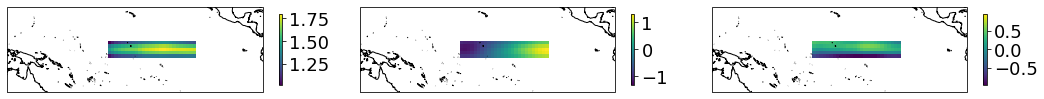

In [36]:
fig, axes = plt.subplots(1,3,subplot_kw={'projection':proj},
                         sharex=True,sharey=True,figsize=(15,3))
for i,ax in enumerate(axes.flat):
    ax.coastlines()
    # eofs are dimensionless unit vectors;
    # multiply them by the square root of the eigenvalues
    # (eigenvalues have units of variance) to get our units back, i.e., °C.
    (s[i]**0.5*eof[i]).plot(ax=ax,transform=data_proj,
                            cmap='viridis',cbar_kwargs={"shrink": 0.4})
    ax.set_extent([130,280,-25,25],crs=data_proj)
    ax.set_title(None)
fig.tight_layout()

# Create spatial *correlation* maps using principal components

- correlation between two random variables $X$ and $Y$ is expressed as $\rho_{X,Y} = \frac{Cov(X,Y)}{\sigma_X\sigma_Y}$

- if $X$, $Y$ are two random variables with zero mean, then the covariance $Cov(X,Y) = E[X\cdot Y]$ is the dot product of $X$ and $Y$

## Correlation with Sea Surface Temperature

In [37]:
sst_all = ds_sst["sst"].fillna(0).values
nt, ny, nx = sst_all.shape
print(sst_all.shape)
sst_all = np.reshape(sst_all,(nt,ny*nx))
print(sst_all.shape)
print(u.shape)

# this is the "matrix" way of doing a regression
X = np.dot((u/u.std(axis=0)).T,sst_all/sst_all.std(axis=0))/nt
sst_eof_corr = np.reshape(X,(n_components,ny,nx))
print(sst_eof_corr.shape)

coords = [("PC",range(1,n_components+1)),
          ("latitude", ds_sst["latitude"].data),
          ("longitude", ds_sst["longitude"].data)]
eof_maps = xr.DataArray(sst_eof_corr, coords=coords)

(863, 89, 180)
(863, 16020)
(863, 130)
(130, 89, 180)


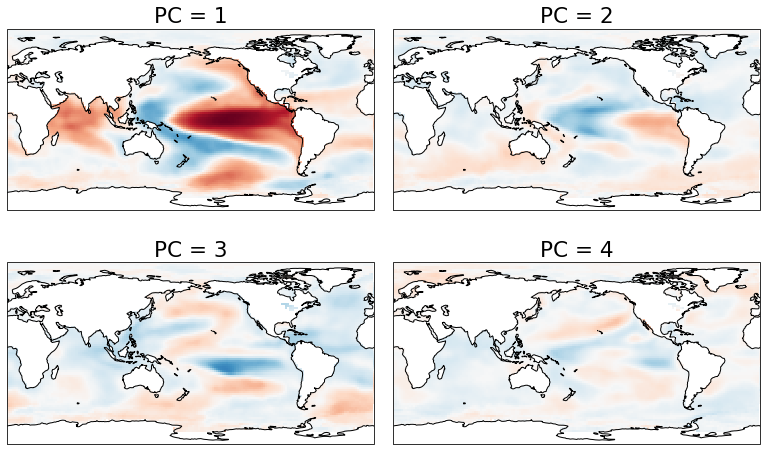

In [38]:
fig, axes = plt.subplots(2,2,subplot_kw={'projection':proj},figsize=(11,7))
for i,ax in enumerate(axes.flat):
    ax.coastlines()
    eof_maps[i].plot(ax=ax,transform=data_proj,
                     cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=False)
fig.tight_layout()

## Correlation with Sea Surface Height

In [39]:
ds_ssh = xr.open_dataset("ssha.nc")
ds_ssh = ds_ssh.rename({'T': 'time', 'Y': 'latitude', 'X': 'longitude'}).set_coords(['longitude', 'latitude', 'time'])

# ds0_ssh = ds_ssh*1.0
ds_ssh = ds_ssh.apply(detrend_)
# ds1_ssh = ds_ssh*1.0
ds_ssh = ds_ssh.groupby("time.month").apply(subtract)
# ds2_ssh = ds_ssh*1.0

# ds1_ssh["ssha"].groupby("time.month").mean().sel(longitude=82,latitude=2).plot(label="climatology")
# ds2_ssh["ssha"].groupby("time.month").mean().sel(longitude=82,latitude=2).plot(label="climatology removed (=0)")
# plt.legend();

In [40]:
ssh_all = ds_ssh["ssha"].fillna(0).values
nt, ny, nx = ssh_all.shape
ssh_all = np.reshape(ssh_all,(nt,ny*nx))
print(ssh_all.shape)
t1 = ds_ssh["time"].data[0].strftime()
t2 = ds_ssh["time"].data[-1].strftime()
pc = ds_pc.sel(time=slice(t1,t2)).sel(n=1)

# this is the "matrix" way of doing a regression
X = np.dot(pc.to_array(),ssh_all/ssh_all.std(axis=0))/nt
X = np.reshape(X,(ny,nx))

coords = [("latitude", ds_ssh["latitude"].data),
          ("longitude", ds_ssh["longitude"].data)]
corr_map = xr.DataArray(X, coords=coords)

(118, 10890)


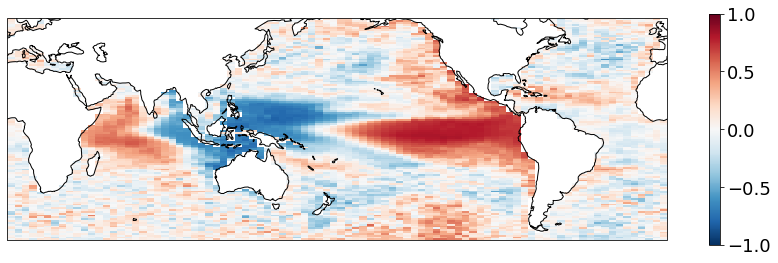

In [41]:
fig, ax = plt.subplots(1,1,subplot_kw={'projection':proj},figsize=(12,4))
ax.coastlines()

corr_map.plot(ax=ax,transform=data_proj,
                     cmap='RdBu_r',vmin=-1,vmax=1,add_colorbar=True)
fig.tight_layout()

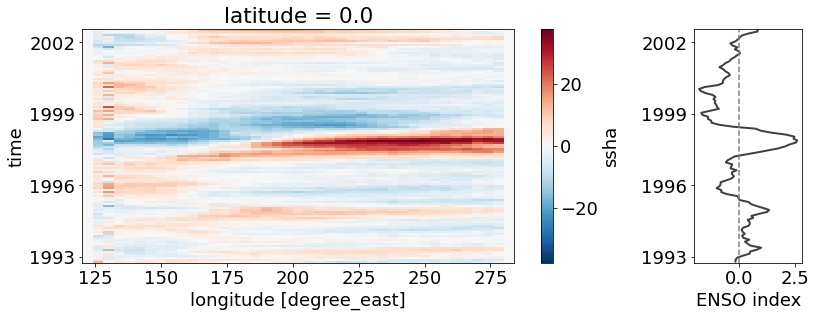

In [42]:
left, width, bottom, height, spacing = 0.1, 0.75, 0.1, 0.65, 0.1
rect_hov = [left, bottom, width, height]
rect_pc1 = [left + width + spacing, bottom, 0.15, height]

fig = plt.figure(figsize=(10, 5))

ax = fig.add_axes(rect_hov)
ds_ssh["ssha"].sel(longitude=slice(120,285),latitude=0).plot(ax=ax,label="climatology removed (=0)")

ax_pc1 = fig.add_axes(rect_pc1, sharey=ax)
ax_pc1.plot(pc.to_array().squeeze(),pc["time"],'k-',lw=2,alpha=0.75)
ax_pc1.set_xlabel("ENSO index")
ax_pc1.axvline(0,ls='--',color='gray');

## Interactive session (30min)

Break out into groups of 2 or 3 and work through notebook `02-Correlation.ipynb`.